<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Classification with Python</font></h1>

In this notebook we try to practice all the classification algorithms that we learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-09-13 14:45:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.07s   

2020-09-13 14:45:22 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [4]:
df = pd.read_csv('loan_train.csv')
df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True) # replace loan_status with numerical values

df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,1,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,1,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,1,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,1,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,1,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convert to date time object 

In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [7]:
df['loan_status'].value_counts()

1    260
0     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [8]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

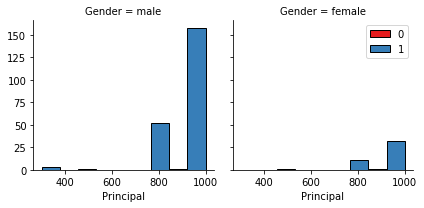

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

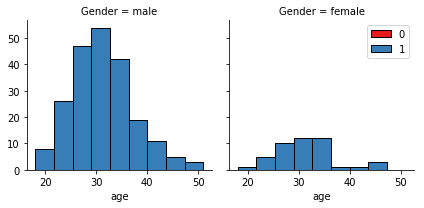

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

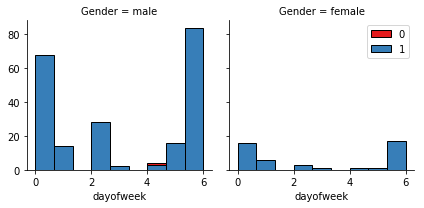

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  1              0.865385
        0              0.134615
male    1              0.731293
        0              0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,1,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,1,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,1,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,1,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,1,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              1              0.750000
                      0              0.250000
High School or Below  1              0.741722
                      0              0.258278
Master or Above       0              0.500000
                      1              0.500000
college               1              0.765101
                      0              0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [18]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [19]:
y = df['loan_status'].values
y[0:5]

array([1, 1, 1, 1, 1])

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [21]:
# Preparing Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test  set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test  set: (70, 8) (70,)


In [23]:
# Preparing the Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 1
while (Ks <= 1):
    Ks = int(input("Please, Enter the max value of K Nearest Neighbor(KNN) you want us to check {greater than 1}, K = "))

mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat  = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])



Please, Enter the max value of K Nearest Neighbor(KNN) you want us to check {greater than 1}, K = 10


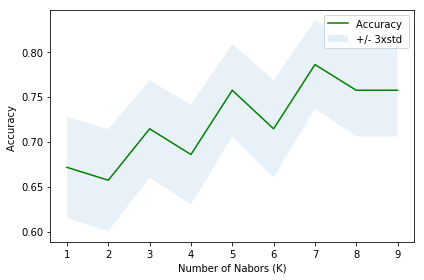

The best accuracy was:  0.7857142857142857 with k= 7


In [24]:
# Visualizing the model and calculating its accuracy
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was: ", mean_acc.max(), "with k=", mean_acc.argmax()+1) 


KNN_best_k = mean_acc.argmax()+1

# Decision Tree

In [25]:
# Preparing Data
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test  set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test  set: (70, 8) (70,)


In [27]:
# Preparing the Model
from sklearn.tree import DecisionTreeClassifier
Depth = 0
DUser = 0
while(Depth <=0 or DUser <=0 or DUser > Depth):
    Depth = int(input("Please, Enter the maximum depth{positive integer, less than 32 if your machine is 32-bit} of the tree: "))
    DUser = int(input("Please, Enter the depth{positive integer, less than 32 if your machine is 32-bit, less than depth}you want to find the Predictes tree at: "))
mean_acc = np.zeros(Depth+1)
accUser = float()
while(Depth > 0):
    DecTree = DecisionTreeClassifier(criterion="entropy", max_depth = Depth)
    DecTree.fit(X_train,y_train)
    predTree = DecTree.predict(X_test)
    mean_acc[Depth] = metrics.accuracy_score(y_test, predTree)
    if Depth == DUser:
        accUser =  mean_acc[Depth]
    Depth-=1

Please, Enter the maximum depth{positive integer, less than 32 if your machine is 32-bit} of the tree: 10
Please, Enter the depth{positive integer, less than 32 if your machine is 32-bit, less than depth}you want to find the Predictes tree at: 4


In [28]:
# calculating model's accuracy
print( "The best accuracy was: ", mean_acc.max(), "at Depth=", mean_acc.argmax()) 

print("DecisionTrees's Accuracy is: ", accUser, "at the desired Depth:", DUser)

dec_tree_best_depth = DUser

The best accuracy was:  0.7857142857142857 at Depth= 1
DecisionTrees's Accuracy is:  0.6142857142857143 at the desired Depth: 4


# Support Vector Machine

In [29]:
# Preparing Data
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test  set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test  set: (70, 8) (70,)


In [30]:
# Preparing the Model

from sklearn import svm
kernelFullName = ['Radial basis function (RBF)', 'Linear', 'Polynomial', 'Sigmoid']
kernel = ['rbf', 'linear', 'poly', 'sigmoid']
mean_acc = np.zeros(4)

for k in range(4):
    clf = svm.SVC(kernel=kernel[k])
    clf.fit(X_train, y_train) 
    yhat = clf.predict(X_test)
    mean_acc[k] = metrics.accuracy_score(y_test, yhat)
    print("SVM's Accuracy for kernel= ",kernelFullName[k],": ", mean_acc[k])



SVM's Accuracy for kernel=  Radial basis function (RBF) :  0.7428571428571429
SVM's Accuracy for kernel=  Linear :  0.7857142857142857
SVM's Accuracy for kernel=  Polynomial :  0.7714285714285715
SVM's Accuracy for kernel=  Sigmoid :  0.7428571428571429


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [31]:
# Calculating Model's accuracy

print( "The best accuracy was: ", mean_acc.max(), "with kernel=", kernelFullName[mean_acc.argmax()]) 

SVM_best_kernel = kernel[mean_acc.argmax()]

The best accuracy was:  0.7857142857142857 with kernel= Linear


# Logistic Regression

In [32]:
# Preparing Data
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test  set:', X_test.shape,  y_test.shape)


Train set: (276, 8) (276,)
Test  set: (70, 8) (70,)


In [33]:
# Preparing the Model

from sklearn.linear_model import LogisticRegression
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

max_accuracy = 0
max_C_solver_acc = ()
C = float(input("Please enter the max regularization value you want, C= "))
step = 0.0
while(step <= 0):
    step = float(input("Please enter the step of the regularization value you want {positive float number}, step= "))
print('\n')
while(C > 0):
    print("at C=", C)
    mean_acc = np.zeros(4)
    for s in range(4):
        LR = LogisticRegression(C=C, solver=solvers[s]).fit(X_train,y_train)
        yhat = LR.predict(X_test)
        mean_acc[s] = metrics.accuracy_score(y_test, yhat)
        print("Logistic Regression's Accuracy for solver=",solvers[s],":", mean_acc[s])
    m = mean_acc.max()
    if m > max_accuracy:
        max_accuracy = m
        max_C_solver_acc = (max_accuracy, solvers[mean_acc.argmax()], C)
    C-=step

Please enter the max regularization value you want, C= 0.01
Please enter the step of the regularization value you want {positive float number}, step= 1


at C= 0.01
Logistic Regression's Accuracy for solver= newton-cg : 0.7857142857142857
Logistic Regression's Accuracy for solver= lbfgs : 0.7857142857142857
Logistic Regression's Accuracy for solver= liblinear : 0.6857142857142857
Logistic Regression's Accuracy for solver= sag : 0.7857142857142857


In [34]:
# Calculating Model's accuracy

print( "The best accuracy was:", max_C_solver_acc[0], "with solver=", max_C_solver_acc[1], "at C=", max_C_solver_acc[2]) 

log_reg_best_solver_C = (max_C_solver_acc[1],  max_C_solver_acc[2])


The best accuracy was: 0.7857142857142857 with solver= newton-cg at C= 0.01


# Model Evaluation using Test set

In [35]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import log_loss

First, download and load the test set:

In [36]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-09-13 14:46:27--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-09-13 14:46:27 (216 MB/s) - ‘loan_test.csv’ saved [3642/3642]



In [37]:
# changing date to datetime object
#test_df['due_date'] = pd.to_datetime(test_df['due_date']) # convet due_date into a datetime object 
#test_df['effective_date'] = pd.to_datetime(test_df['effective_date']) # convet effective_date into a datetime object 

# number of loan status
#print(test_df['loan_status'].value_counts())

# replace empty strings with np.nan then drop all nan and print the number of nulls
#test_df['loan_status'].replace('', np.nan, inplace=True)
#test_df.dropna(subset=['loan_status'], inplace=True)
#print(test_df['loan_status'].isnull().sum()) #0

# delete all nan
#test_df[~test_df['loan_status'].isna()]

# drop rows
#test_df.drop([55,346], axis=0,inplace=True)

# should be done after train_test_split
#X = preprocessing.StandardScaler().fit(X).transform(X) #Data Standardization give data zero mean and unit variance

# transpose and reshape
#X = X.transpose()
#y = y.reshape(6, -1)
#y_new_test = y_new_test.reshape(y_new_test.shape[:1])

# if an index persists in the memory. So, use
# df.reset_index() 

#X = X.iloc[:54,] # delete rows after 54

#features =pd.DataFrame(np.hstack([features,pd.get_dummies(df['education'])])) # converting the education into numerical values


def printRC(df):
    r, c = df.shape
    print(">>>rows:", r, "col:", c)

### Load Test set for evaluation 

In [38]:
# preparing the data
test_df = pd.read_csv('loan_test.csv') # saving the dataset as a dataframe

test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True) # replace gender with numerical values

test_df['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[1,0],inplace=True) # replace loan_status with numerical values
newY = test_df['loan_status'].values # saving the loan_status -target- in y

features = test_df[['Principal','terms','age','Gender']] # saving the features in 'features'

features = pd.concat([features,pd.get_dummies(test_df['education'])], axis=1) # converting the education into numerical values

#print(test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)) # all 'Bechalor' and 'Master or Above' are Paidoff. So, no need for them 
features.drop(columns=['Master or Above'], inplace=True) # dropping the 'Master or Above'
features.drop(columns=['Bechalor'], inplace=True) # dropping the 'Bechalor'


newX = features # now we have 6- fetuers and will save them in 'X'
newX = preprocessing.StandardScaler().fit(newX).transform(newX) # Data Standardization give data zero mean and unit variance
 



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.


In [39]:
#  preparing the models
# ----------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4) # resting the data again to avoid any memory indexing errors

X_train = np.delete(X_train, 4, 1)  # delete the forth column of X_train
X_train = np.delete(X_train, 5, 1)  # delete fifth column of X_train

# KNN model

KNN_model = KNeighborsClassifier(KNN_best_k).fit(X_train,y_train) # we will train the model on the old data with the best K 
KNN_best_yhat  = KNN_model.predict(newX)

# decession tree model

decTree_model = DecisionTreeClassifier(criterion="entropy", max_depth = dec_tree_best_depth)
decTree_model.fit(X_train,y_train)
DecTree_best_yhat = decTree_model.predict(newX)

# SVM model

SVM_model = svm.SVC(kernel=SVM_best_kernel)
SVM_model.fit(X_train, y_train) 
SVM_best_yhat = SVM_model.predict(newX)

# logistic regression model

LR_model = LogisticRegression(C=log_reg_best_solver_C[1], solver=log_reg_best_solver_C[0]).fit(X_train,y_train)
Log_reg_best_yhat = LR_model.predict(newX)

In [40]:
# jaccard index

jaccard_KNN = jaccard_similarity_score(newY, KNN_best_yhat)

jaccard_DT = jaccard_similarity_score(newY, DecTree_best_yhat)
print ("for the Decision Tree, the best jaccard similarity score is:", jaccard_DT)

jaccard_SVM = jaccard_similarity_score(newY, SVM_best_yhat)
print ("for the Support Vector Machine, the best jaccard similarity score is:", jaccard_SVM)

jaccard_LR = jaccard_similarity_score(newY, Log_reg_best_yhat)
print ("for the Logistic Regression, the best jaccard similarity score is:", jaccard_LR)


for the Decision Tree, the best jaccard similarity score is: 0.7407407407407407
for the Support Vector Machine, the best jaccard similarity score is: 0.7407407407407407
for the Logistic Regression, the best jaccard similarity score is: 0.7407407407407407


In [41]:
# f1 score

f1Score_KNN = f1_score(newY, KNN_best_yhat)
print ("for the KNN, the best f1 score is:",f1Score_KNN)

f1Score_DT = f1_score(newY, DecTree_best_yhat)
print ("for the Decision Tree, the best f1 score is:", f1Score_DT)

f1Score_SVM = f1_score(newY, SVM_best_yhat)
print ("for the Support Vector Machine, the best f1 score is:", f1Score_SVM)

f1Score_LR = f1_score(newY, Log_reg_best_yhat)
print ("for the Logistic Regression, the best f1 score is:", f1Score_LR)


for the KNN, the best f1 score is: 0.8131868131868133
for the Decision Tree, the best f1 score is: 0.851063829787234
for the Support Vector Machine, the best f1 score is: 0.851063829787234
for the Logistic Regression, the best f1 score is: 0.851063829787234


In [42]:
# log loss

logLoss_LR = log_loss(newY, Log_reg_best_yhat)
print ("for the Logistic Regression, the best log loss is:", logLoss_LR)


for the Logistic Regression, the best log loss is: 8.95470488690319


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

In [43]:
data = {'Algorithm':  ['KNN', 'Decision Tree ', 'SVM', 'LogisticRegression'],
        'Jaccard': [jaccard_KNN, jaccard_DT, jaccard_SVM, jaccard_LR],
        'F1-score': [f1Score_KNN, f1Score_DT, f1Score_SVM, f1Score_LR],
        'LogLoss':['NA', 'NA', 'NA', logLoss_LR]
        }

data = pd.DataFrame (data, columns = ['Algorithm','Jaccard', 'F1-score', 'LogLoss'])
data.style.set_properties(**{'background-color': '#5499C7 ','color': '#212F3C','border-color': 'Black'})
#data.head()

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.685185,0.813187,NA
1,Decision Tree,0.740741,0.851064,NA
2,SVM,0.740741,0.851064,NA
3,LogisticRegression,0.740741,0.851064,8.9547


| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>